# Project 2 - Coronavirus

This project consist to estimate the SIR model with the most updated data from WHO.

In [88]:
import pandas as pd
import numpy as np
from scipy import integrate
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, median_absolute_error
from scipy.integrate import odeint
from scipy.optimize import differential_evolution, minimize
import matplotlib.pyplot as plt

In [89]:
import PDEparams as pde

## Data from World Health Organization
#### Only laboratory-confirmed, exclude clinically diagnose

In [90]:
data = pd.read_csv('CoV2019.csv')
china = data["China"][:27]#data["China"][:27]
days = data["Days"][:27]
total = data["Total"][:27]
deaths_china = data["Death China"][:27]
other = data["Other"]
china_total = data["China"]
days_total = data["Days"]
deaths_china_total = data["Death China"]
deaths_outside_total = data["Death Outside"]

### Ploting raw data

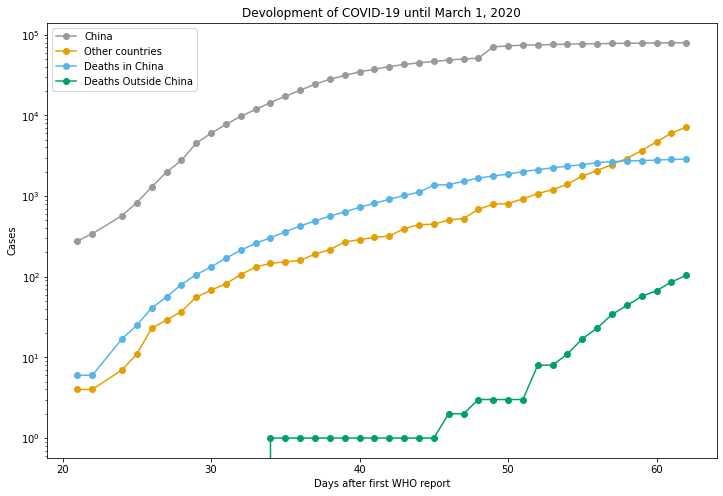

In [91]:
plt.figure(figsize=(12, 8))
plt.title("Devolopment of COVID-19 until March 1, 2020")
plt.plot(days_total, china_total, '-o', label="China")
plt.plot(days_total, other, '-o', label="Other countries")
plt.plot(days_total, deaths_china_total, '-o', label="Deaths in China")
plt.plot(days_total, deaths_outside_total, '-o', label="Deaths Outside China")
plt.yscale('log')
plt.ylabel("Cases")
plt.xlabel("Days after first WHO report")
plt.legend()
plt.show()

### Defining the model

We use a SIR model:

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma\,I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}$$

Susceptible -> Infected -> Recovered

$$\begin{align}
\beta &= \text{Contact Rate } \times \text{ Probability of Transmission}\\
\sigma &= \text{Incubation Rate}\\
\gamma &= \text{Recovery Rate}
\end{align}$$

Incubation Period: 1-14 Days, most commonly 5 days (WHO)

### Initial Conditions

In [102]:
Hubei = 5917*10**4
Guangdong = 11346*10**4
Henan = 9605*10**4
Zhejiang = 5737*10**4
Hunan = 6899*10**4
Anhui = 6324*10**4
Jiangxi = 4648*10**4
Wuhan = 11.08e6
N = 56*10**3                        # estimate of people affected by lock down
init_I = 1
init_R = 1

## Using PDEparams library

In [93]:
#Setting data
dataPDE = data[["Days","China","Death China"]]
dataPDE.head()

,Days,China,Death China
0,21,278,6
1,22,341,6
2,24,571,17
3,25,830,25
4,26,1297,41


### Approach

We want to know how the population is gona be affected by the pandemi. So by the supposing the pandemic follow a ISR model then we will explore the future of this trends.

First, we will use the PDEparams library to have an approx of parameters. To simplfy the data notice how 

$$
\frac{\mathrm{d} S}{\mathrm{d} t} + \frac{\mathrm{d} R}{\mathrm{d} t} +\frac{\mathrm{d} I}{\mathrm{d} t} = 0
 $$
 
 That means the amount of populations is constant over the days, say a population $N$. And $N=S+I+R$. So we can reduce our system of equations by changing $S = N - (I+R)$. Now the system is:
 
$$\begin{align}
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{\left( N - (I+R)\right)I}{N} - \gamma\,I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}$$

Now the problem is in terms of the number of cases and the number of deaths.

In [124]:
#Setting model
N = Wuhan
def SIR1(z, t, b, g):
    '''The input z corresponds to the current state of the system, z = [x, y]. Since the input is in 1D, no 
    pre-processing is needed.
    
    t is the current time.
    
    b and g correspond to the unknown parameters.
    '''
    
    I, R = z
    
    return [b*(N-(I+R))*I/N-g*I, g*I]


#Initial values

def initial_x():
    return init_I

def initial_y():
    return init_R

In [125]:
my_model = pde.PDEmodel(dataPDE, SIR1, [initial_x, initial_y], bounds=[(0, 1), (0,1)], 
                        param_names=[r'$\beta$', r'$\gamma$'], nvars=2, ndims=0, nreplicates=1, obsidx=None, outfunc=None)


In [126]:
my_model.initial_condition

array([1, 1])

In [127]:
my_model.fit()

    $\beta$  $\gamma$
0  0.197809  0.007263


In [27]:
my_model.best_params

,$\beta$,$\gamma$
0,0.289113,0.0


In [128]:
my_model.best_error

526017604.04481906

In [28]:
my_model.likelihood_profiles()

parameters:   0%|          | 0/2 [00:00<?, ?it/s]

values within parameters:   0%|          | 0/100 [00:00<?, ?it/s]

values within parameters:   0%|          | 0/100 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


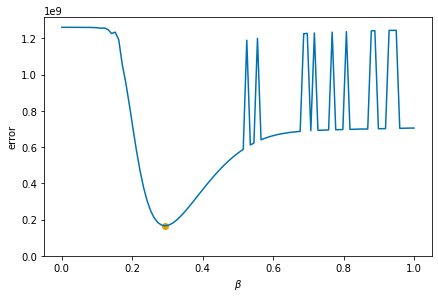

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


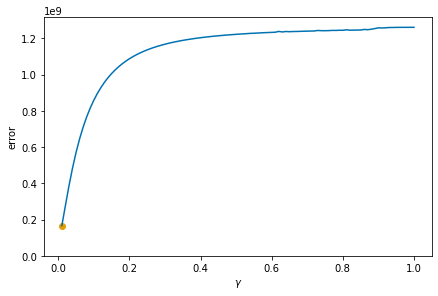

In [14]:
my_model.plot_profiles()

--------

In [111]:
#Setting data
dataPDE = data[["Days","China","Death China"]]
dataPDE.head()

#Setting model
def SIR(z, t, b, g, Np):
    '''The input z corresponds to the current state of the system, z = [x, y]. Since the input is in 1D, no 
    pre-processing is needed.
    
    t is the current time.
    
    b and g correspond to the unknown parameters.
    '''
    
    I, R = z
    
    return [b*(Np-(I+R))*I/Np-g*I, g*I]


#Initial values

def initial_x():
    return init_I

def initial_y():
    return init_R

my_model2 = pde.PDEmodel(dataPDE, SIR, [initial_x, initial_y], bounds=[(0, 1), (0,1),(1e6,1e9)], 
                        param_names=[r'$\beta$', r'$\gamma$', r'N'], nvars=2, ndims=0, nreplicates=1, obsidx=None, outfunc=None)




In [113]:
my_model2.fit()

    $\beta$  $\gamma$             N
0  0.199556   0.00854  3.578037e+06


In [117]:
my_model.best_error

526017604.0221429

In [122]:
my_model2.best_params

,$\beta$,$\gamma$,N
0,0.199556,0.00854,3.578037e+06


In [18]:
my_model2.likelihood_profiles()

parameters:   0%|          | 0/3 [00:00<?, ?it/s]

values within parameters:   0%|          | 0/100 [00:00<?, ?it/s]

values within parameters:   0%|          | 0/100 [00:00<?, ?it/s]

values within parameters:   0%|          | 0/100 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


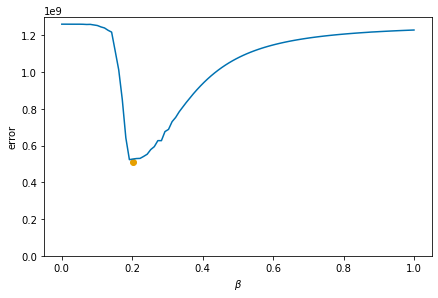

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


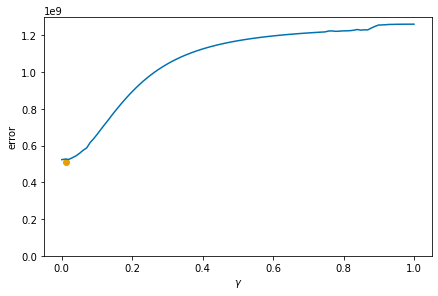

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


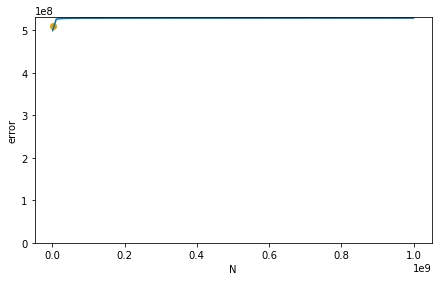

In [19]:
my_model2.plot_profiles()

----

## Solving the given ODE

In [49]:
from scipy.integrate import odeint

In [56]:
t = np.arange(0,70,1)
beta = 2.03353167e-01
gamma = 1.12502561e-02
Np = 1.46228381e+06

sol = odeint(SIR, #model
             [init_I,init_R], #init conditions
             t, #times
             args=(beta, #beta
                   gamma, #gamma
                   Np) # N
            )

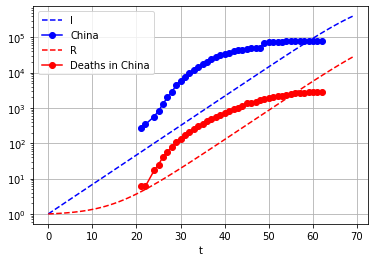

In [75]:
plt.plot(t, sol[:, 0], 'b--', label='I')

plt.plot(days_total, china_total, 'b-o', label="China")

plt.plot(t, sol[:, 1], 'r--', label='R')

plt.plot(days_total, deaths_china_total, 'r-o', label="Deaths in China")

plt.yscale('log')

plt.legend(loc='best')

plt.xlabel('t')

plt.grid()

plt.show()

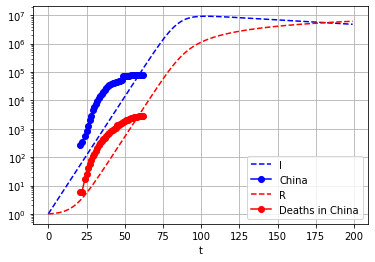

In [129]:
t = np.arange(0,200,1)
beta = 0.197809
gamma = 0.007265
Np = 11.08e+06

sol = odeint(SIR, #model
             [init_I,init_R], #init conditions
             t, #times
             args=(beta, #beta
                   gamma, #gamma
                   Np) # N
            )

plt.plot(t, sol[:, 0], 'b--', label='I')

plt.plot(days_total, china_total, 'b-o', label="China")

plt.plot(t, sol[:, 1], 'r--', label='R')

plt.plot(days_total, deaths_china_total, 'r-o', label="Deaths in China")

plt.yscale('log')

plt.legend(loc='best')

plt.xlabel('t')

plt.grid()

plt.show()